In [1]:
import torch
import yaml 
import matplotlib.pyplot as plt
import torch.nn.functional as F
import os
import numpy as np

from model.VAE.pl_VAE import PlVAE
from dataset.datasetH5 import HDF5Dataset


/usr/local/lib/python3.10/dist-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Params

In [59]:
dossier = "lightning_logs/version_79552/checkpoints"
fichiers = [f for f in os.listdir(dossier) if os.path.isfile(os.path.join(dossier, f))]

print(fichiers)

['epoch=29-step=484080.ckpt']


In [60]:
path_checkpoint = "lightning_logs/version_79552/checkpoints/epoch=29-step=484080.ckpt"
path_config = "lightning_logs/version_79552/config_model.yaml"

# Loading

In [61]:
with open(path_config, 'r') as file:
    config = yaml.safe_load(file)

In [62]:
config

{'dataset': {'conversion_dict_path': '/projects/pnria/julien/autofill/conversion_dict_all.json',
  'hdf5_file': '/projects/pnria/julien/autofill/all_data.h5',
  'metadata_filters': {'material': ['ag'],
   'technique': ['les'],
   'type': ['simulation']},
  'requested_metadata': ['shape', 'material'],
  'sample_frac': 1.0,
  'transform': {'q': {'PaddingTransformer': {'pad_size': 80, 'value': 0}},
   'y': {'MinMaxNormalizer': {},
    'PaddingTransformer': {'pad_size': 80, 'value': 0}}}},
 'devices': '1',
 'model': {'args': {'dilation': 1,
   'down_channels': [32, 64, 128],
   'in_channels': 1,
   'input_dim': 80,
   'latent_dim': 64,
   'output_channels': 1,
   'strat': 'y',
   'up_channels': [128, 64, 32]},
  'vae_class': 'VAE',
  'output_transform_log': False},
 'name': 'les_ag_gpu1',
 'training': {'T_max': 25,
  'batch_size': 64,
  'beta': 0.005,
  'eta_min': 1e-07,
  'max_lr': 1e-05,
  'num_epochs': 300,
  'num_gpus': 1,
  'num_nodes': 1,
  'num_workers': 3,
  'patience': 10}}

# Model

In [63]:
model = PlVAE(config)

VAE Architecture:
	Input Dimension: 80
	Latent Dimension: 64
	In Channels: 1
	Down Channels: [32, 64, 128]
	Up Channels: [128, 64, 32]
	Output Channels: 1
	Flattened Size: 640
	Encoder Architecture: Sequential(
  (0): Conv1d(1, 32, kernel_size=(3,), stride=(2,), padding=(1,))
  (1): ReLU()
  (2): Conv1d(32, 32, kernel_size=(3,), stride=(1,), padding=(1,))
  (3): ReLU()
  (4): Conv1d(32, 64, kernel_size=(3,), stride=(2,), padding=(1,))
  (5): ReLU()
  (6): Conv1d(64, 64, kernel_size=(3,), stride=(1,), padding=(1,))
  (7): ReLU()
  (8): Conv1d(64, 128, kernel_size=(3,), stride=(2,), padding=(1,))
  (9): ReLU()
  (10): Conv1d(128, 128, kernel_size=(3,), stride=(1,), padding=(1,))
  (11): ReLU()
  (12): Flatten(start_dim=1, end_dim=-1)
  (13): Linear(in_features=1280, out_features=640, bias=True)
  (14): ReLU()
)
	Decoder Architecture: Sequential(
  (0): Linear(in_features=64, out_features=1280, bias=True)
  (1): Unflatten(dim=1, unflattened_size=(128, 10))
  (2): ConvTranspose1d(128, 64, 

In [64]:
checkpoint = torch.load(path_checkpoint, map_location=torch.device('cuda' if torch.cuda.is_available() else 'cpu'))
model.load_state_dict(checkpoint['state_dict'])

<All keys matched successfully>

# Dataset

In [65]:
dataset = HDF5Dataset(
hdf5_file = config["dataset"]["hdf5_file"],
metadata_filters = config["dataset"]["metadata_filters"],
conversion_dict_path = config["dataset"]["conversion_dict_path"],
sample_frac = config["dataset"]["sample_frac"],
transform =  config["dataset"]["transform"],
requested_metadata =  config["dataset"]["requested_metadata"],
)
print("========================================")

Applying filters: 100%|██████████| 3/3 [00:34<00:00, 11.51s/it]


╒══════════════════════════════════════════════╕
│ Dataset Initialization Info                 │
╞══════════════════════════════════════════════╡
│ File: /projects/pnria/julien/autofill/all_data.h5 │
│ Total samples: 2924722                    │
│ Samples filtered: 1290824                 │
│ Requested fraction: 1.0                    │
│ Fractioned samples: 1290824                │
│ Requested metadata: 2                      │


# Plot

In [71]:
def plot_les(idx_sample):
    one_sample = dataset[idx_sample]
    
    one_sample = {k:v.unsqueeze(0) if "data_" in k else v for k,v in one_sample.items()}
    x, recon, mu, logvar, z = model(one_sample)

    plt.figure(figsize=(5, 3))
    plt.plot(x.detach().numpy().flatten(), label="truth")
    plt.plot(recon.detach().numpy().flatten(), label="pred recon")
    plt.title("Plot")
    plt.legend()
    plt.tight_layout()
    plt.show()

In [72]:
def plot_saxs(idx_sample):
    one_sample = dataset[idx_sample]
    
    one_sample = {k:v.unsqueeze(0) if "data_" in k else v for k,v in one_sample.items()}
    x, recon, mu, logvar, z = model(one_sample)

    plt.figure(figsize=(5, 3))
    plt.loglog(x.detach().numpy().flatten(), label="truth")
    plt.loglog(recon.detach().numpy().flatten(), label="pred recon")
    plt.title("Plot")
    plt.legend()
    plt.tight_layout()
    plt.show()

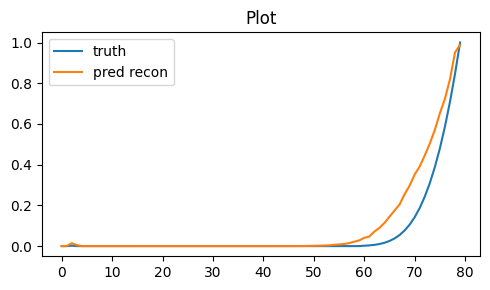

In [73]:
plot_les(14)

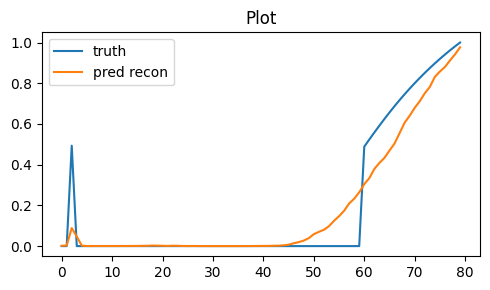

In [74]:
plot_les(19)

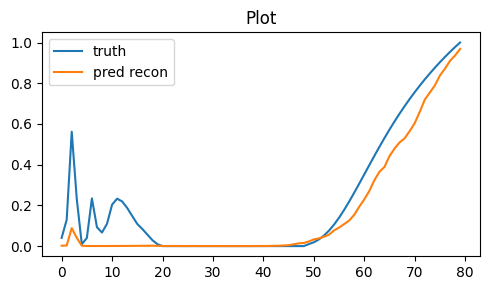

In [75]:
plot_les(789)

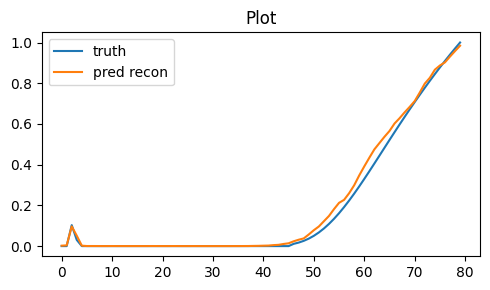

In [76]:
plot_les(4981)